In [2]:
import os
import numpy as np
from dataclasses import dataclass, fields
from VASP_job.code.main import VASP_job

import pandas as pd
import ase
from ase.spacegroup import crystal

# from pyiron.atomistics.structure.atoms import ase_to_pyiron
# from pyiron.atomistics.structure.atoms import pyiron_to_ase

import matplotlib.pyplot as plt


# Define a custom formatting function for vectors in pandas
format_vector = lambda vector: '[' + ', '.join(['{:.10f}'.format(x) for x in vector]) + ']'

In [20]:
def set_ntasks(ntasks="40"):
   ntasks = float(ntasks)
   NPAR0 = round(np.sqrt(ntasks))
   NPAR = NPAR0
   res = ntasks % NPAR

   dN_list = [-1, 1]
   idN = 0
   dNf = 1
   print(NPAR)
   while res != 0:
      NPAR = NPAR0 + dN_list[idN]*dNf

      idN += 1
      if idN > 1:
         idN = 0
         dNf += 1

      res = ntasks % NPAR
      print(idN, NPAR)

   return int(ntasks), int(NPAR)

set_ntasks(160)

13
1 12
0 14
1 11
0 15
1 10


(160, 10)

In [21]:
np.sqrt(60)

7.745966692414834

In [2]:
a = 3.95
alpha = 90
structure = crystal(('Ga', 'Mn', 'N'),
                       basis=[(0.00, 0.00, 0.00), (0.00, 0.50, 0.50), (0.50, 0.50, 0.50)],
                       spacegroup=221,
                       cellpar=[a, a, a, alpha, alpha, alpha])
structure.symbols.species()

{'Ga', 'Mn', 'N'}

In [3]:
# Create a defition that does all this?

executable_path= "/home/emendive/workbench/work/from_claix/codes/VASP/vasp.5.4.4-flag4/bin"
potential_path = "/home/emendive/workbench/work/from_claix/codes/VASP/potentials/potpaw_PBE"
vasp = VASP_job(verbose="low", executable_path=executable_path, potential_path=potential_path)

In [4]:
Dtheta = 120 * np.pi/180
theta = -Dtheta

number_of_atoms = len(structure)
vasp.io.magnetic_inputs.magdirs   = []
vasp.io.magnetic_inputs.ms    = []
# vasp.io.magnetic_inputs.B_CONSTRs = []
for i in range(number_of_atoms):
   if 'Mn' == structure.get_chemical_symbols()[i]:
      theta += Dtheta
      vasp.io.magnetic_inputs.magdirs.append([np.cos(theta), np.sin(theta), 0])
      vasp.io.magnetic_inputs.ms.append(0.9)
      # vasp.io.magnetic_inputs.B_CONSTRs.append([0.0, 0.0, 0.0])
   else:
      vasp.io.magnetic_inputs.magdirs.append([-2.0, 1.0, 0.0])
      vasp.io.magnetic_inputs.ms.append(False)
      # vasp.io.magnetic_inputs.B_CONSTRs.append([0.0, 0.0, 0.0])

In [5]:
vasp.prepare_relaxation(NSW="50")
# vasp.prepare_bfields(LAMBDA="10", I_CONSTRAINED="4")
vasp.set_calculation(structure, vasp.io.magnetic_inputs)

In [6]:
vasp.df

,elements,positions,magdirs,ms,betahs,magmoms,B_CONSTRs
0,Ga,"[0.0, 0.0, 0.0]","[-2.0, 1.0, 0.0]",False,inf,"[-2.0, 1.0, 0.0]","[0, 0, 0]"
1,Mn,"[0.0, 1.975, 1.975]","[1.0, 0.0, 0]",0.9,10.0,"[0.9879537913586907, 0.13835352834838316, 0.06...","[0, 0, 0]"
2,Mn,"[1.975, 0.0, 1.975]","[-0.4999999999999998, 0.8660254037844387, 0]",0.9,10.0,"[-0.67696615201501, 0.7294905415011468, 0.0977...","[0, 0, 0]"
3,Mn,"[1.975, 1.975, 0.0]","[-0.5000000000000004, -0.8660254037844384, 0]",0.9,10.0,"[-0.514981980463476, -0.8449619413459789, -0.1...","[0, 0, 0]"
4,N,"[1.975, 1.975, 1.975]","[-2.0, 1.0, 0.0]",False,inf,"[-2.0, 1.0, 0.0]","[0, 0, 0]"


In [7]:
df_magmoms = vasp.df["magmoms"].apply(format_vector)
df_magmoms

0      [-2.0000000000, 1.0000000000, 0.0000000000]
1       [0.9879537914, 0.1383535283, 0.0693224879]
2      [-0.6769661520, 0.7294905415, 0.0977771900]
3    [-0.5149819805, -0.8449619413, -0.1443359881]
4      [-2.0000000000, 1.0000000000, 0.0000000000]
Name: magmoms, dtype: object

In [9]:
from collections import OrderedDict

# Sample ordered set using OrderedDict
ordered_set = OrderedDict.fromkeys([3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5])

# Convert ordered set to a list while preserving order
my_list = list(ordered_set)

# Display the result
print(my_list)

[3, 1, 4, 5, 9, 2, 6]


In [8]:
vasp.io.constr_INCAR_parameters.I_CONSTRAINED = "4"
vasp.structure.kpoints = "2 2 2"
vasp.df = [structure, vasp.io.magnetic_inputs]
df_magmoms = vasp.df["magmoms"].apply(format_vector)
vasp.df

AttributeError: 'io' object has no attribute 'constr_INCAR_parameters'

In [ ]:
vasp.structure.kpoints

'2 2 2'

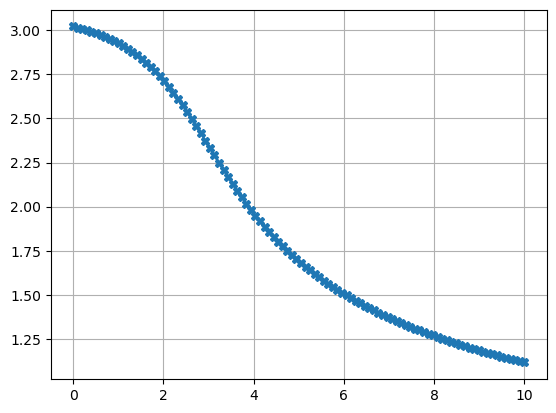

In [ ]:
random_number = np.random.random()
random_number = 0.9963636835363322
betahs = np.linspace(0, 10, 100)
thetas = []
for betah in betahs:
   thetas.append( vasp.magnetism.get_theta_mag(random_number, betah) )
plt.plot(betahs, thetas, '-X')
plt.grid(visible=True)

In [ ]:
a=0.0
if a is False:
   print("h")

In [ ]:
vasp.io.magnetic_inputs.betahs

In [ ]:
vasp.io.cwd = "asf"
vasp.io.INCAR_file

In [ ]:
vasp.prepare_calculation()

AttributeError: 'magnetism' object has no attribute 'prepare_magnetism'

In [ ]:
vasp.structure.species

In [ ]:
vasp.magnetism.betahs

In [ ]:
structure.set_initial_magnetic_moments([[0, 0, 2], [0, 0, 0], [0, 0, 2], [0, 0, 2], [0, 0, 2]])

In [ ]:
structure = ase_to_pyiron(structure)
Nrepeat=2
structure.set_repeat([Nrepeat,Nrepeat,Nrepeat])

In [ ]:
ase.build.make_supercell(structure, )

In [ ]:
structure.get_initial_magnetic_moments()

In [ ]:
list( structure.symbols.species() )

In [ ]:
structure.get_chemical_symbols()

In [ ]:
structure.get_chemical_symbols().count("Mn")

In [ ]:
structure.cell.array

In [ ]:
list( structure.positions )

In [ ]:
structure.positions

Inputs

- positions
- magmoms
- element
- betah

In [ ]:
lattice = pd.DataFrame({
   "avec"  : structure.cell[0],
   "bvec"  : structure.cell[1],
   "cvec"  : structure.cell[2]
})
lattice

In [ ]:
atoms = pd.DataFrame({
   "elements"  : structure.get_chemical_symbols(),
   "positions" : list( structure.positions ),
   "magmoms"   : list( structure.get_initial_magnetic_moments() ),
   "betahs"    : [1.0, False, 1.0, 0.3, 0.2],
   "B_CONSTRs" : [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1]]
})
atoms = atoms.sort_values("elements")
atoms

In [ ]:
elements = atoms["elements"].tolist()
elements_red = list(dict.fromkeys(elements))
print(elements)
print(elements_red)

In [ ]:
executable_path= "/home/emendive/workbench/work/from_claix/codes/VASP/vasp.5.4.4-flag4/bin"
potential_path = "/home/emendive/workbench/work/from_claix/codes/VASP/potentials/potpaw_PBE"
vasp = VASP_job(verbose="low", executable_path=executable_path, potential_path=potential_path)

vasp.io.constr_INCAR_parameters.I_CONSTRAINED = "5"
vasp.structure.kpoints = "2 2 2"
vasp.prepare_calculation(atoms, structure)

In [ ]:
vasp.io.cwd = '/home/emendive/workbench/devel/gitclones/VASP_job/'
vasp.io.cwd

In [ ]:
vasp.io.constr_INCAR_parameters.I_CONSTRAINED = "5"
vasp.structure.kpoints = "2 2 2"
vasp.prepare_calculation(atoms, structure)

In [ ]:
vasp.structure.elements

In [ ]:
vasp.structure.species

In [ ]:
vasp.structure.elements.count("Mn")

In [ ]:
vasp.io.constr_INCAR_parameters.I_CONSTRAINED

In [ ]:
vasp.magnetism.B_CONSTRs

In [ ]:
vasp.io.cwd

In [ ]:
vasp.io.standard_INCAR_parameters

In [ ]:
vasp.structure.kpoints = "1 1 1"
vasp.structure.kpoints

In [ ]:
vasp.structure.elements = ["Ni"]
vasp.io.potential_files.Ni = "Ni"

In [ ]:
class A(object):
    def __init__(self, val):
        self.idx = val

    @property    
    def idx(self):
        return self._idx

    @idx.setter
    def idx(self, val):
        try:
            value1, value2 = val
        except ValueError:
            raise ValueError("Pass an iterable with two items")
        else:
            """ This will run only if no exception was raised """
            self._idx = value1+value2

In [ ]:
my_A = A([1,2])
my_A.idx
my_A.idx = [1,3]
my_A.idx